# Assignment 3

## Ahmed Haj Abdel Khaleq

## 8223727

# 2 Data Preparation


(40, 25, 3)


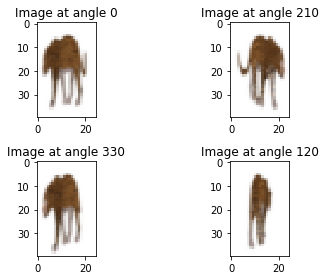

In [674]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from skimage import io, transform, util

# returns a dict object to house numpy arrays for each starting position, the y labels which are the angles, where the starting position is the key
def dict_offsets(img_list):
    offset_dict = {}
    
    for i in range(len(img_list)):
        offset_dict[i] = find_offset(i, img_list)
        
    
    return offset_dict
        
        

# returns a list of image pairs in a a +-45 deg angle offset given a starting position along with the accompanying angle labels
def find_offset(start_pos, img_list):
    offset_pairs = []
    y_label = []
    
    image = img_list[start_pos]
    
    # find +45 deg images
    pointer = 0
    for i in range(1, 16):
        pointer+=1
        new_ang = (start_pos + pointer) % 120
        new_image = img_list[new_ang]
        
        offset_ang = (new_ang*3) - (start_pos*3)
        ang_diff = (offset_ang + 180) % 360 - 180
        
        offset_pairs.append(np.dstack((image, new_image)))
        y_label.append(ang_diff)
        
        
        
    
    # find -45 deg images
    pointer = 0
    for i in range(1, 16):
        pointer+=1
        new_ang = (start_pos - pointer) % 120
        new_image = img_list[new_ang]
        
        offset_ang = (new_ang*3) - (start_pos*3) 
        ang_diff = (offset_ang + 180) % 360 - 180
        
        offset_pairs.append(np.dstack((image, new_image)))
        y_label.append(ang_diff)
    
    
    # find 0 deg offset pair (image with itself)
    offset_pairs.append(np.dstack((image, image)))
    y_label.append(0)
    
    return(offset_pairs,y_label)

        


# hardcoding paths for easy access
image_path = "Synthetic_Leopard_Circle/"

# retrieving the directory of each path 
image_dir = os.listdir(image_path)

# sort the directories for easy reference-checking
image_dir.sort()


# create lists to house images for faster pair creation
img_list = []
for file in image_dir:
    if file.endswith(".png"):
        # read image in 
        image = io.imread(image_path+ file)
        
        # crop whitespace
        image2 = util.crop(image, crop_width= ((170, 100), (125, 125), (0,0)), copy=False)
        
        # resize image
        image3 = transform.resize(image2, (40, 25, 3))
                                  
        img_list.append(image3)
        
                                  
                                
offset_dict = dict_offsets(img_list)

# plot to show images after transformation (before depthwise stacking)
figure, axes = plt.subplots(nrows=2, ncols=2)
ax = axes.ravel()

ax[0].imshow(img_list[0], cmap='gray')
ax[0].set_title("Image at angle 0")

ax[1].imshow(img_list[70] , cmap='gray')
ax[1].set_title("Image at angle 210")

ax[2].imshow(img_list[110], cmap='gray')
ax[2].set_title("Image at angle 330")

ax[3].imshow(img_list[40] , cmap='gray')
ax[3].set_title("Image at angle 120")

print(img_list[0].shape)
figure.tight_layout()


In [675]:
import random

# Given start positions, generate set and target set from offset_dict
def generate_dataset(startpos_list, offset_dict):
    X = []
    y = []
    
    for i in startpos_list:
        x1, y1 = offset_dict[i]
        
        for pair in x1:
            X.append(pair)
            
        for label in y1:
            y.append(label)
            
        
    X = np.asarray(X)
    y = np.asarray(y)
    
    return (X, y)
        

# Shuffle starting positions
start_positions = list(offset_dict.keys())
random.shuffle(start_positions)

# Generate training, validation and testing datasets
X_train, y_train = generate_dataset(start_positions[:90], offset_dict)
X_valid, y_valid = generate_dataset(start_positions[90:100], offset_dict)
X_test,  y_test  = generate_dataset(start_positions[100:], offset_dict)


print('{:<23s}{:^5}{:^5}{:^8s}{:^5}'.format('Training set size:',len(X_train), len(y_train), 'Shape:', str(X_train.shape)))
print('{:<23s}{:^5}{:^5}{:^8s}{:^5}'.format('Validation set size:',len(X_valid), len(y_valid), 'Shape:', str(X_valid.shape)))
print('{:<23s}{:^5}{:^5}{:^8s}{:^5}'.format('Test set size:',len(X_test), len(y_test), 'Shape:', str(X_test.shape)))


Training set size:     2790 2790  Shape: (2790, 40, 25, 6)
Validation set size:    310  310  Shape: (310, 40, 25, 6)
Test set size:          620  620  Shape: (620, 40, 25, 6)


# 3 Classification Network

In [694]:
## import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Lambda
from tensorflow.keras import backend as K



model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', input_shape=(40,25,6)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(31, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])




print(model.summary())


Model: "sequential_155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_375 (Conv2D)          (None, 40, 25, 32)        4832      
_________________________________________________________________
max_pooling2d_290 (MaxPoolin (None, 20, 12, 32)        0         
_________________________________________________________________
conv2d_376 (Conv2D)          (None, 20, 12, 64)        51264     
_________________________________________________________________
max_pooling2d_291 (MaxPoolin (None, 10, 6, 64)         0         
_________________________________________________________________
flatten_158 (Flatten)        (None, 3840)              0         
_________________________________________________________________
dense_366 (Dense)            (None, 120)               460920    
_________________________________________________________________
dense_367 (Dense)            (None, 31)             

In [695]:
nClasses = 31

y_train_shift1 = y_train/3
y_train_shift2 = y_train_shift1 - y_train_shift1.min()
y_train_k = tensorflow.keras.utils.to_categorical(y_train_shift2, num_classes = nClasses)

y_valid_shift1 = y_valid/3
y_valid_shift2 = y_valid_shift1 - y_valid_shift1.min()
y_valid_k = tensorflow.keras.utils.to_categorical(y_valid_shift2, num_classes = nClasses)


reduce_lr = [ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=4, min_lr=1e-6, verbose=0),
             tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=8, verbose=1)]

batchSize = 256
nEpochs = 100

print(y_train_k.shape)

history = model.fit(X_train, y_train_k, batch_size=batchSize, epochs=nEpochs, verbose=1, 
                    validation_data=(X_valid, y_valid_k), 
                    callbacks=reduce_lr)

(2790, 31)
Train on 2790 samples, validate on 310 samples
Epoch 1/100
2790/2790 [==============================] - 28s 10ms/sample - loss: 3.4467 - acc: 0.0297 - val_loss: 3.4349 - val_acc: 0.0290
Epoch 2/100
2790/2790 [==============================] - 4s 1ms/sample - loss: 3.4372 - acc: 0.0319 - val_loss: 3.4339 - val_acc: 0.0323
Epoch 3/100
2790/2790 [==============================] - 4s 1ms/sample - loss: 3.4339 - acc: 0.0341 - val_loss: 3.4342 - val_acc: 0.0290
Epoch 4/100
2790/2790 [==============================] - 4s 2ms/sample - loss: 3.4340 - acc: 0.0240 - val_loss: 3.4335 - val_acc: 0.0387
Epoch 5/100
2790/2790 [==============================] - 4s 2ms/sample - loss: 3.4331 - acc: 0.0419 - val_loss: 3.4328 - val_acc: 0.0419
Epoch 6/100
2790/2790 [==============================] - 5s 2ms/sample - loss: 3.4320 - acc: 0.0427 - val_loss: 3.4307 - val_acc: 0.0258
Epoch 7/100
2790/2790 [==============================] - 4s 2ms/sample - loss: 3.4267 - acc: 0.0448 - val_loss: 3.4180

Epoch 60/100
2790/2790 [==============================] - 4s 1ms/sample - loss: 0.7857 - acc: 0.7075 - val_loss: 0.8380 - val_acc: 0.6903
Epoch 61/100
2790/2790 [==============================] - 4s 1ms/sample - loss: 0.8100 - acc: 0.6957 - val_loss: 0.9355 - val_acc: 0.6000
Epoch 62/100
2790/2790 [==============================] - 4s 2ms/sample - loss: 0.7745 - acc: 0.7140 - val_loss: 0.9584 - val_acc: 0.6129
Epoch 63/100
2790/2790 [==============================] - 4s 2ms/sample - loss: 0.8019 - acc: 0.6749 - val_loss: 0.8676 - val_acc: 0.6226
Epoch 64/100
2790/2790 [==============================] - 18s 6ms/sample - loss: 0.7506 - acc: 0.7129 - val_loss: 0.8891 - val_acc: 0.6387
Epoch 65/100
2790/2790 [==============================] - 4s 1ms/sample - loss: 0.7232 - acc: 0.7333 - val_loss: 0.8281 - val_acc: 0.6710
Epoch 66/100
2790/2790 [==============================] - 4s 1ms/sample - loss: 0.6810 - acc: 0.8011 - val_loss: 0.7862 - val_acc: 0.7032
Epoch 67/100
2790/2790 [=========

620/620 [==============================] - 1s 1ms/sample - loss: 0.7065 - acc: 0.8290

Dataset     Accuracy 
----------------------------------------
Training   0.9121863842010498
Validation 0.8129032254219055
Testing    0.8290322422981262


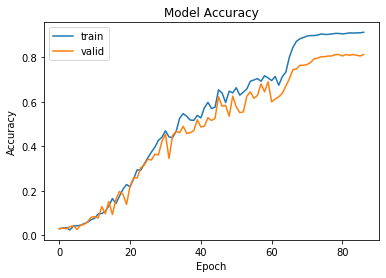

In [696]:
from sklearn.metrics import confusion_matrix

y_test_shift1 = y_test/3
y_test_shift2 = y_test_shift1 - y_test_shift1.min()
y_test_k = tensorflow.keras.utils.to_categorical(y_test_shift2, num_classes = nClasses)

train_acc = model.evaluate(X_train, y_train_k)
val_acc   = model.evaluate(X_valid, y_valid_k)
test_acc  = model.evaluate(X_test,  y_test_k)

print('\n{:<11s}{:^10s}'.format('Dataset', 'Accuracy'))
print("-" * 40)
print('{:<11s}{:^10}'.format('Training', train_acc[1]))
print('{:<11s}{:^10}'.format('Validation', val_acc[1]))
print('{:<11s}{:^10}'.format('Testing', test_acc[1]))


k = ''
if 'accuracy' in history.history :
    k = 'accuracy'    

if 'acc' in history.history :
    k = 'acc'
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    


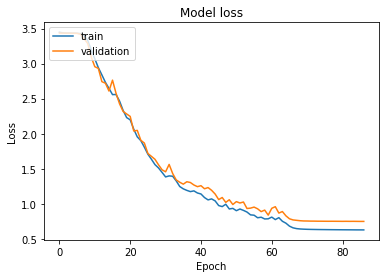

In [697]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Discussion

Due to our 7 layer limitation, and about 500,000 trainable parameters, I would expect our model to be able to learn the training set very well. Therefore, it is important to ensure that our model does not overfit by data by implementing early stopping after 8 iterations where the validation accuracy does not increase (number found by experimenting).

Due to using an adaptive learning rate, we can see the performance of our Classification Network improving slowly but surely while requiring a large amount of epochs in both the model loss and model accuracy curves.

Our accuracy on the 3 datasets are exactly what we expected, and we can see that our model is not overfitting. An accuracy of 83% on the test set is very high because this is a 31 class classification problem where random guessing would yield an accuracy 3.2%. Therefore our model is performing significantly better than random guessing.

# 4 Regression Network

In [701]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', input_shape=(40,25,6)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(1, activation='tanh'))

opt = keras.optimizers.Adam(learning_rate=0.01)

reduce_lr = [ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=3, min_lr=1e-10, verbose=0),
            tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', mode='min', patience=8, verbose=1)]

model.compile(loss=tensorflow.keras.losses.MeanSquaredError(),
              optimizer='adam',
              metrics=['mse'])


print(model.summary())


Model: "sequential_157"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_378 (Conv2D)          (None, 40, 25, 32)        4832      
_________________________________________________________________
max_pooling2d_293 (MaxPoolin (None, 20, 12, 32)        0         
_________________________________________________________________
conv2d_379 (Conv2D)          (None, 20, 12, 64)        51264     
_________________________________________________________________
max_pooling2d_294 (MaxPoolin (None, 10, 6, 64)         0         
_________________________________________________________________
flatten_160 (Flatten)        (None, 3840)              0         
_________________________________________________________________
dense_370 (Dense)            (None, 120)               460920    
_________________________________________________________________
dense_371 (Dense)            (None, 1)              

In [702]:
from sklearn.preprocessing import MinMaxScaler

# Change scale to [-1, 1]
scale = MinMaxScaler((-1, 1))
y_train_k = y_train.reshape(-1, 1)
y_train_k = scale.fit_transform(y_train_k)

y_val_k = y_valid.reshape(-1, 1)
y_val_k   = scale.fit_transform(y_val_k)

y_test_k = y_test.reshape(-1, 1)
y_test_k  = scale.fit_transform(y_test_k)

history = model.fit(X_train, y_train_k, batch_size=batchSize, epochs=nEpochs, verbose=1, 
                    validation_data=(X_valid, y_val_k),
                    callbacks=reduce_lr)

Train on 2790 samples, validate on 310 samples
Epoch 1/100
2790/2790 [==============================] - 29s 10ms/sample - loss: 1.0527 - mean_squared_error: 1.0527 - val_loss: 0.4114 - val_mean_squared_error: 0.4114
Epoch 2/100
2790/2790 [==============================] - 4s 2ms/sample - loss: 0.3715 - mean_squared_error: 0.3715 - val_loss: 0.3562 - val_mean_squared_error: 0.3562
Epoch 3/100
2790/2790 [==============================] - 4s 2ms/sample - loss: 0.3582 - mean_squared_error: 0.3582 - val_loss: 0.3571 - val_mean_squared_error: 0.3571
Epoch 4/100
2790/2790 [==============================] - 4s 2ms/sample - loss: 0.3557 - mean_squared_error: 0.3557 - val_loss: 0.3554 - val_mean_squared_error: 0.3554
Epoch 5/100
2790/2790 [==============================] - 4s 2ms/sample - loss: 0.3547 - mean_squared_error: 0.3547 - val_loss: 0.3546 - val_mean_squared_error: 0.3546
Epoch 6/100
2790/2790 [==============================] - 4s 2ms/sample - loss: 0.3521 - mean_squared_error: 0.3521 -

Epoch 98/100
2790/2790 [==============================] - 4s 2ms/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 99/100
2790/2790 [==============================] - 4s 2ms/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 100/100
2790/2790 [==============================] - 4s 2ms/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0059 - val_mean_squared_error: 0.0059


<class 'numpy.ndarray'>
Dataset       MSE    
----------------------------------------
Training   0.0023320145710581507
Validation 0.005936587891952242
Testing    0.006539647231548266


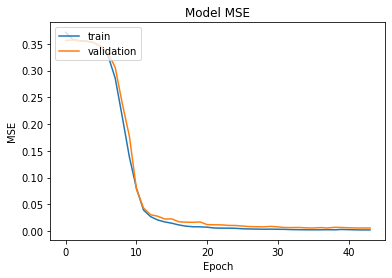

In [706]:
from sklearn.metrics import mean_squared_error
import math

train_mse = model.predict(X_train)
valid_mse = model.predict(X_valid)
test_mse  = model.predict(X_test)

print(type(valid_mse))


print('{:<11s}{:^10s}'.format('Dataset', 'MSE'))
print("-" * 40)
print('{:<11s}{:^10}'.format('Training', mean_squared_error(y_train_k, train_mse)))
print('{:<11s}{:^10}'.format('Validation', mean_squared_error(y_val_k, valid_mse)))
print('{:<11s}{:^10}'.format('Testing', mean_squared_error(y_test_k, test_mse)))


k = ''
if 'loss' in history.history :
    k = 'loss'    

if 'mse' in history.history :
    k = 'mse'
    
if k != '' :    
    plt.plot(history.history[k][1:45])
    plt.plot(history.history['val_'+k][1:45])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## Discussion

Due to how well our previous model did on the classification problem, I decided to use the exact same archeticture but with a regression layer (where the activation function is tanh since it produced an output from -1 to 1 like the assignment requires). My expectation is that our model will perform well here as well because the archeticture has already performed well on the previous problem.


The MSE curve shows us that our model is learning quite well, and is not overfitting the training set due to implementing early stopping. 

Our MSE value for the test set is very low which means our model is very close to the line of best fit, meaning our model is performing well.


 # 5 Basic Transfer Learning
 
 Convert the images to grayscale, and use a size of 32x32 since that is the smallest size allowed by VGG.

(32, 32)


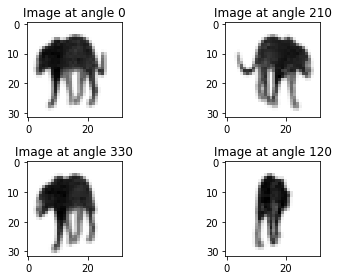

In [673]:
from skimage.color import rgb2gray

# create lists to house images for faster pair creation
grey_list = []
for file in image_dir:
    if file.endswith(".png"):
        # read image in 
        image = io.imread(image_path+ file)
        
        # greyscale image
        image = rgb2gray(image)
        
        #print(image.shape)
        
        # crop whitespace
        image2 = util.crop(image, crop_width= ((170, 100), (125, 125)), copy=False)
        
        
        # resize image
        image3 = transform.resize(image2, (32, 32))
                                  
        grey_list.append(image3)
        
                                  
                                
offset_dict = dict_offsets(grey_list)

# plot to show images after transformation (before depthwise stacking)
figure, axes = plt.subplots(nrows=2, ncols=2)
ax = axes.ravel()

ax[0].imshow(grey_list[0], cmap='gray')
ax[0].set_title("Image at angle 0")

ax[1].imshow(grey_list[70] , cmap='gray')
ax[1].set_title("Image at angle 210")

ax[2].imshow(grey_list[110], cmap='gray')
ax[2].set_title("Image at angle 330")

ax[3].imshow(grey_list[40] , cmap='gray')
ax[3].set_title("Image at angle 120")

print(grey_list[0].shape)
figure.tight_layout()


In [524]:
# function that adds a blank depth channel
def add_depth(X_input):
    X_output = []
    for image in X_input:
        X_output.append(np.dstack((image, np.zeros((32, 32)))))
        
    
    return np.asarray(X_output)

# Shuffle starting positions
start_positions = list(offset_dict.keys())
random.shuffle(start_positions)

# Generate training, validation and testing datasets
X_train, y_train = generate_dataset(start_positions[:90], offset_dict)
X_valid, y_valid = generate_dataset(start_positions[90:100], offset_dict)
X_test,  y_test  = generate_dataset(start_positions[100:], offset_dict)

# add blank depth channel
X_train = add_depth(X_train)
X_valid = add_depth(X_valid)
X_test = add_depth(X_test)


print('{:<23s}{:^5}{:^5}{:^8s}{:^5}'.format('Training set size:',len(X_train), len(y_train), 'Shape:', str(X_train.shape)))
print('{:<23s}{:^5}{:^5}{:^8s}{:^5}'.format('Validation set size:',len(X_valid), len(y_valid), 'Shape:', str(X_valid.shape)))
print('{:<23s}{:^5}{:^5}{:^8s}{:^5}'.format('Test set size:',len(X_test), len(y_test), 'Shape:', str(X_test.shape)))

Training set size:     2790 2790  Shape: (2790, 32, 32, 3)
Validation set size:    310  310  Shape: (310, 32, 32, 3)
Test set size:          620  620  Shape: (620, 32, 32, 3)


In [525]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
 
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))

In [526]:
for layer in vgg_model.layers:
    layer.trainable = False

# We will have to use the functional API    

# last layers output
x = vgg_model.layers[-1].output
# Flatten as before
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='tanh')(x)

vgg_model_transfer = Model(inputs=vgg_model.input, outputs=x)
vgg_model_transfer.compile(loss=tensorflow.keras.losses.MeanSquaredError(),
              optimizer='adam',
              metrics=['mse'])
print(vgg_model_transfer.summary())

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [530]:
# Change scale to [-1, 1]
scale = MinMaxScaler((-1, 1))
y_train_k = y_train.reshape(-1, 1)
y_train_k = scale.fit_transform(y_train_k)

y_val_k = y_valid.reshape(-1, 1)
y_val_k   = scale.fit_transform(y_val_k)

y_test_k = y_test.reshape(-1, 1)
y_test_k  = scale.fit_transform(y_test_k)

reduce_lr = [ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=3, min_lr=1e-10, verbose=0),
            tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', mode='min', patience=8, verbose=1)]

history = vgg_model_transfer.fit(X_train, y_train_k, batch_size=batchSize, epochs=nEpochs, verbose=1, 
                    validation_data=(X_valid, y_val_k),
                    callbacks=reduce_lr)

Train on 2790 samples, validate on 310 samples
Epoch 1/100
2790/2790 [==============================] - 37s 13ms/sample - loss: 0.1082 - mean_squared_error: 0.1082 - val_loss: 0.1063 - val_mean_squared_error: 0.1063
Epoch 2/100
2790/2790 [==============================] - 37s 13ms/sample - loss: 0.0810 - mean_squared_error: 0.0810 - val_loss: 0.0875 - val_mean_squared_error: 0.0875
Epoch 3/100
2790/2790 [==============================] - 37s 13ms/sample - loss: 0.0705 - mean_squared_error: 0.0705 - val_loss: 0.0770 - val_mean_squared_error: 0.0770
Epoch 4/100
2790/2790 [==============================] - 37s 13ms/sample - loss: 0.0638 - mean_squared_error: 0.0638 - val_loss: 0.0742 - val_mean_squared_error: 0.0742
Epoch 5/100
2790/2790 [==============================] - 37s 13ms/sample - loss: 0.0583 - mean_squared_error: 0.0583 - val_loss: 0.0712 - val_mean_squared_error: 0.0712
Epoch 6/100
2790/2790 [==============================] - 37s 13ms/sample - loss: 0.0542 - mean_squared_error

Epoch 49/100
2790/2790 [==============================] - 37s 13ms/sample - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 50/100
2790/2790 [==============================] - 37s 13ms/sample - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 51/100
2790/2790 [==============================] - 37s 13ms/sample - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 52/100
2790/2790 [==============================] - 37s 13ms/sample - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 53/100
2790/2790 [==============================] - 37s 13ms/sample - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 54/100
2790/2790 [==============================] - 37s 13ms/sample - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0112 - val_mean_sq

<class 'numpy.ndarray'>
Dataset       MSE    
----------------------------------------
Training   0.003844523876747605
Validation 0.009837452311832697
Testing    0.010637686197797166


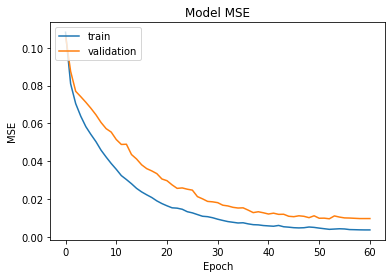

In [532]:
train_mse = vgg_model_transfer.predict(X_train)
valid_mse = vgg_model_transfer.predict(X_valid)
test_mse  = vgg_model_transfer.predict(X_test)

print(type(valid_mse))


print('{:<11s}{:^10s}'.format('Dataset', 'MSE'))
print("-" * 40)
print('{:<11s}{:^10}'.format('Training', mean_squared_error(y_train_k, train_mse)))
print('{:<11s}{:^10}'.format('Validation', mean_squared_error(y_val_k, valid_mse)))
print('{:<11s}{:^10}'.format('Testing', mean_squared_error(y_test_k, test_mse)))


k = ''
if 'loss' in history.history :
    k = 'loss'    

if 'mse' in history.history :
    k = 'mse'
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## Discussion

Since we were only allowed to add 3 layers at most to the pre-trained VGG model, we end up with only 131,000 trainable parameters, which is lower than the number of trainable parameters in our previous model. Therefore I expect this model to perform worse than the model in part 4.


As before, early stopping has been implemented to prevent overfitting, and an adaptive learning rate is used.

By looking at our MSE curve, we can see that our model is not overfitting. And that our Testing MSE value (along with all of the other MSE values) are worse than that of the model in part 4 as expected (0.01 vs 0.006). 

# 5.1 Non-sequential Model and Fine Tuning 

Inspiration Example: https://stackoverflow.com/questions/59695637/i-am-trying-to-merge-2-pretrained-keras-model-but-failed

In [707]:
from tensorflow.keras.layers import concatenate

model = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(32,32,3))

# remove 14 layers for faster processing
model = Model(model.input, model.layers[-13].output)

# Set vgg layers as non-trainable
model.trainable = False
inp = model.input
out = model.output

model2 = VGG16(include_top=False,weights='imagenet', input_tensor=None, input_shape=(32,32,3))

# remove 14 layers for faster processing
model2 = Model(model2.input, model2.layers[-13].output)

# Set vgg layers as non-trainable
model2.trainable = False

# rename layers in the 2 parallel inputs so that the model compiles
for layer in model2.layers:
    layer._name = layer.name + str("_2")
    


inp2 = model2.input
out2 = model2.output

merged = concatenate([out, out2])
merged = Flatten()(merged)
merged = Dense(512, activation='relu')(merged)
merged = Dense(1, activation='tanh')(merged)

twin_model = Model([inp, inp2], merged)
twin_model.summary()

Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_88 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_89_2 (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 32, 32, 64)   1792        input_88[0][0]                   
__________________________________________________________________________________________________
block1_conv1_2 (Conv2D)         (None, 32, 32, 64)   1792        input_89_2[0][0]                 
___________________________________________________________________________________________

In [628]:
# Change scale to [-1, 1]
scale = MinMaxScaler((-1, 1))
y_train_k = y_train.reshape(-1, 1)
y_train_k = scale.fit_transform(y_train_k)

y_val_k = y_valid.reshape(-1, 1)
y_val_k   = scale.fit_transform(y_val_k)

y_test_k = y_test.reshape(-1, 1)
y_test_k  = scale.fit_transform(y_test_k)

reduce_lr = [ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=3, min_lr=1e-10, verbose=0),
            tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', mode='min', patience=8, verbose=1)]

twin_model.compile(loss=tensorflow.keras.losses.MeanSquaredError(),
              optimizer='adam',
              metrics=['mse'])

history = twin_model.fit([X_train,X_train], y_train_k, batch_size=batchSize, epochs=30, verbose=1, 
                    validation_data=([X_valid, X_valid], y_val_k),
                    callbacks=reduce_lr)

Train on 2790 samples, validate on 310 samples
Epoch 1/30
2790/2790 [==============================] - 34s 12ms/sample - loss: 170.1366 - mean_squared_error: 170.1366 - val_loss: 80.9383 - val_mean_squared_error: 80.9383
Epoch 2/30
2790/2790 [==============================] - 11s 4ms/sample - loss: 40.0417 - mean_squared_error: 40.0417 - val_loss: 41.3983 - val_mean_squared_error: 41.3983
Epoch 3/30
2790/2790 [==============================] - 11s 4ms/sample - loss: 14.5630 - mean_squared_error: 14.5630 - val_loss: 15.1691 - val_mean_squared_error: 15.1691
Epoch 4/30
2790/2790 [==============================] - 12s 4ms/sample - loss: 5.3917 - mean_squared_error: 5.3917 - val_loss: 4.9840 - val_mean_squared_error: 4.9840
Epoch 5/30
2790/2790 [==============================] - 11s 4ms/sample - loss: 1.8534 - mean_squared_error: 1.8534 - val_loss: 1.6682 - val_mean_squared_error: 1.6682
Epoch 6/30
2790/2790 [==============================] - 11s 4ms/sample - loss: 0.6194 - mean_squared_er

Dataset       MSE    
----------------------------------------
Training   0.006823951687336408
Validation 0.011931813032885001
Testing    0.01396217828122602


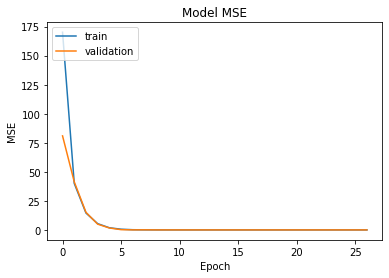

In [629]:
train_mse = twin_model.predict([X_train, X_train])
valid_mse = twin_model.predict([X_valid, X_valid])
test_mse  = twin_model.predict([X_test,  X_test])


print('{:<11s}{:^10s}'.format('Dataset', 'MSE'))
print("-" * 40)
print('{:<11s}{:^10}'.format('Training', mean_squared_error(y_train_k, train_mse)))
print('{:<11s}{:^10}'.format('Validation', mean_squared_error(y_val_k, valid_mse)))
print('{:<11s}{:^10}'.format('Testing', mean_squared_error(y_test_k, test_mse)))


k = ''
if 'loss' in history.history :
    k = 'loss'    

if 'mse' in history.history :
    k = 'mse'
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## Discussion

As we have not fine-tuned our model yet, it is expected that our model will have a similar performance to that of the previous model used in part 5 since only the last 3 layers in this model are trainable while the rest is not trainable.

we can also see that our Model MSE curve is quite steep, this could be because we are using a twin network with 2 VGG architectures working in parallel.

By looking at the MSE values, we can see that this model is performing slightly worse than that of the model used in part 5. I expect this model to perform the best out of all the previous models once fine-tuning is fully implemented. 

In [640]:
# change fine-tuning parameters
model.trainable = True
model2.trainable = True

for i in range(-1, -5, -1):
    twin_model.layers[i].trainable = False


twin_model.compile(loss=tensorflow.keras.losses.MeanSquaredError(),
              optimizer='adam',
              metrics=['mse'])

history = twin_model.fit([X_train,X_train], y_train_k, batch_size=batchSize, epochs=nEpochs, verbose=1, 
                    validation_data=([X_valid, X_valid], y_val_k),
                    callbacks=reduce_lr)


Train on 2790 samples, validate on 310 samples
Epoch 1/100
2790/2790 [==============================] - 44s 16ms/sample - loss: 2.6551 - mean_squared_error: 2.6551 - val_loss: 0.2185 - val_mean_squared_error: 0.2185
Epoch 2/100
2790/2790 [==============================] - 21s 8ms/sample - loss: 0.1340 - mean_squared_error: 0.1340 - val_loss: 0.1301 - val_mean_squared_error: 0.1301
Epoch 3/100
2790/2790 [==============================] - 20s 7ms/sample - loss: 0.0894 - mean_squared_error: 0.0894 - val_loss: 0.0889 - val_mean_squared_error: 0.0889
Epoch 4/100
2790/2790 [==============================] - 21s 7ms/sample - loss: 0.0702 - mean_squared_error: 0.0702 - val_loss: 0.0777 - val_mean_squared_error: 0.0777
Epoch 5/100
2790/2790 [==============================] - 20s 7ms/sample - loss: 0.0581 - mean_squared_error: 0.0581 - val_loss: 0.0721 - val_mean_squared_error: 0.0721
Epoch 6/100
2790/2790 [==============================] - 21s 8ms/sample - loss: 0.0467 - mean_squared_error: 0.0

2790/2790 [==============================] - 20s 7ms/sample - loss: 5.5376e-04 - mean_squared_error: 5.5376e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 00048: early stopping


Dataset       MSE    
----------------------------------------
Training   0.000553759596120975
Validation 0.0010302464880839982
Testing    0.0010544782498450892


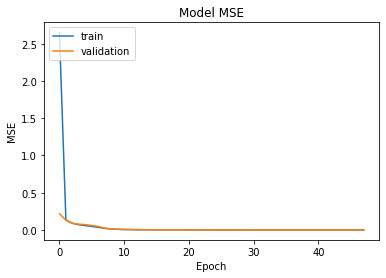

In [641]:
train_mse = twin_model.predict([X_train, X_train])
valid_mse = twin_model.predict([X_valid, X_valid])
test_mse  = twin_model.predict([X_test,  X_test])


print('{:<11s}{:^10s}'.format('Dataset', 'MSE'))
print("-" * 40)
print('{:<11s}{:^10}'.format('Training', mean_squared_error(y_train_k, train_mse)))
print('{:<11s}{:^10}'.format('Validation', mean_squared_error(y_val_k, valid_mse)))
print('{:<11s}{:^10}'.format('Testing', mean_squared_error(y_test_k, test_mse)))


k = ''
if 'loss' in history.history :
    k = 'loss'    

if 'mse' in history.history :
    k = 'mse'
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## Discussion 

As mentioned earlier, this model now has the highest number of trainable parameters, along with the VGG layers as well after fine-tuning. 

By looking at the MSE curve, we can see that the fine-tuned model is learning the data extremely well, and is not overfitting.


By looking at the MSE scores, we can see that this model has by far the lowest MSE values out of all the models that I have used in this assignment, which means this model produces the closest line of best fit, and is therefore outperforming the other models. 



## Ahmed Haj Abdel Khaleq

## 8223727